## Housing Price Estimates 

- Data Source: `Kaggle`


#### Tasks:
- **Data Pre-Processing**
- **EDA**
- **Merge Additional Data by geo/zip**
- **K-Means Clustering**
- **Estimate Price**

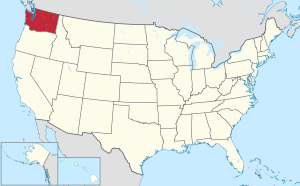

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split as SPLIT
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw = pd.read_csv('/Users/shebanaderzad/Documents/DSCI_550/kc_house_data.csv')
df_raw.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


## Merge Additional Data
- `Zip` or `city` as **Primary Key**
- Crime Data, Population Data, etc.

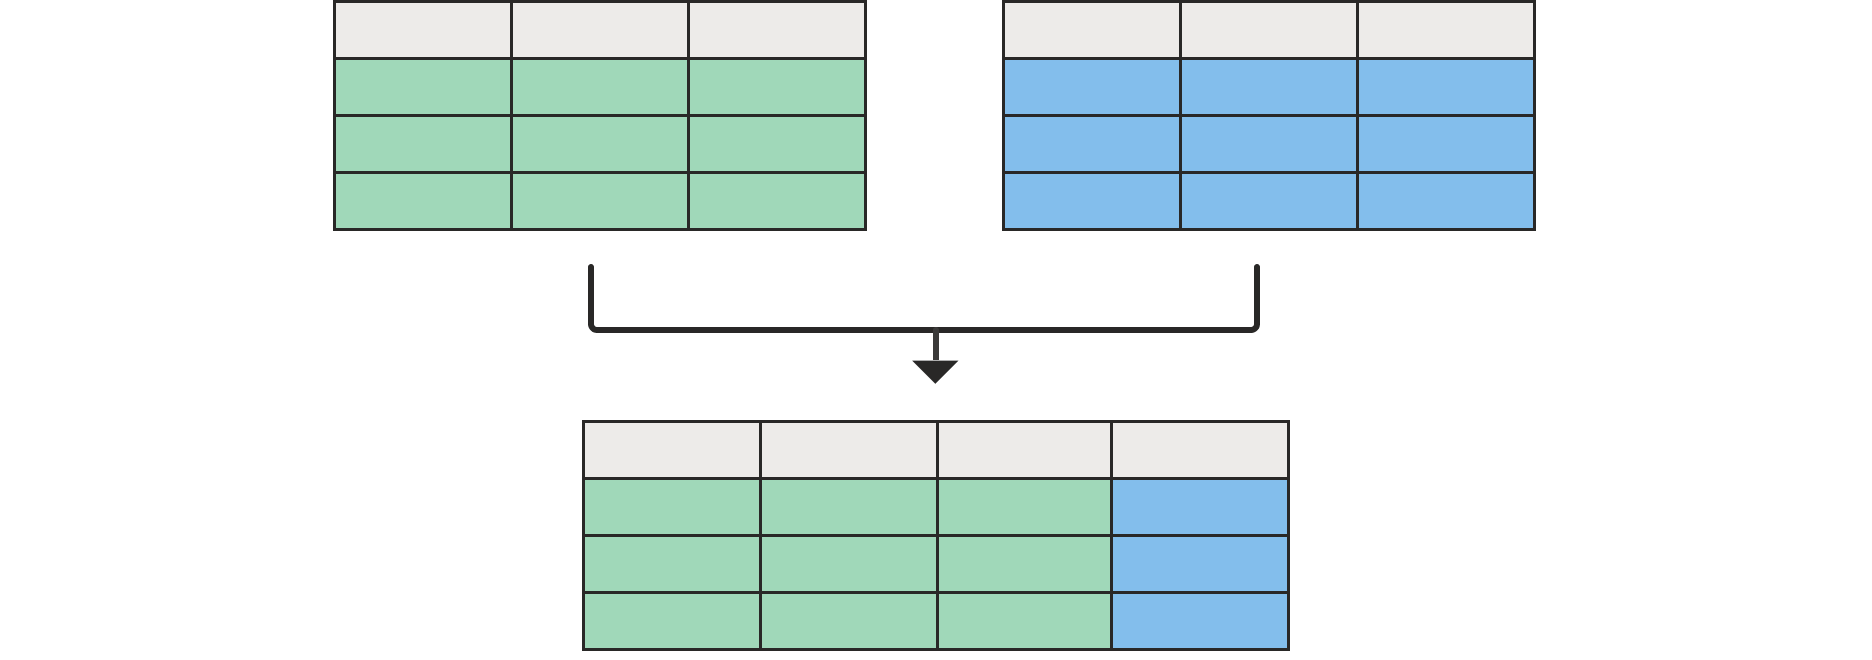

In [3]:
#Population Data #ON QI DATA
zip_df = pd.read_csv('population_by_zip_2010.csv').groupby('zipcode')['population'].max().reset_index() 
df_raw = df_raw.merge(zip_df, left_on='zipcode', right_on='zipcode', how='left') #Relational Join

In [4]:
#School Data

## Cleansing 🧽
- Null Values Omitted
- Outliers exceding 3 Z-scores (99.7% data distribution) extracted 

In [5]:
#Output z-score ranges for data distribution of a feature
def dist_range(df, col, z): 
    upper = round(df[col].mean() + (df[col].std())*z,4)
    lower = round(df[col].mean() - (df[col].std())*z,4)
    if lower<0:lower=0
    print(f'{col.title()} {z} Z-scores of Data: ({lower},{upper})') 

In [6]:
dist_range(df_raw, 'bathrooms',3) #QI DATA
dist_range(df_raw, 'bedrooms',3)
dist_range(df_raw, 'sqft_living',3)
dist_range(df_raw, 'price',3)

Bathrooms 3 Z-scores of Data: (0,4.4252)
Bedrooms 3 Z-scores of Data: (0.5807,6.161)
Sqft_Living 3 Z-scores of Data: (0,4835.2224)
Price 3 Z-scores of Data: (0,1641469.7312)


In [7]:
# Remove Outliers in Analysis Columns
df = df_raw.query('bathrooms <=5 and bedrooms <=7 and sqft_living <= 4500 and price<1500000')

In [8]:
import scipy
#Kurtosis, Original + Cleansed
scipy.stats.kurtosis(np.array(df_raw['price'])),  scipy.stats.kurtosis(np.array(df['price'])) 

(34.577262255687536, 1.6373459257029523)

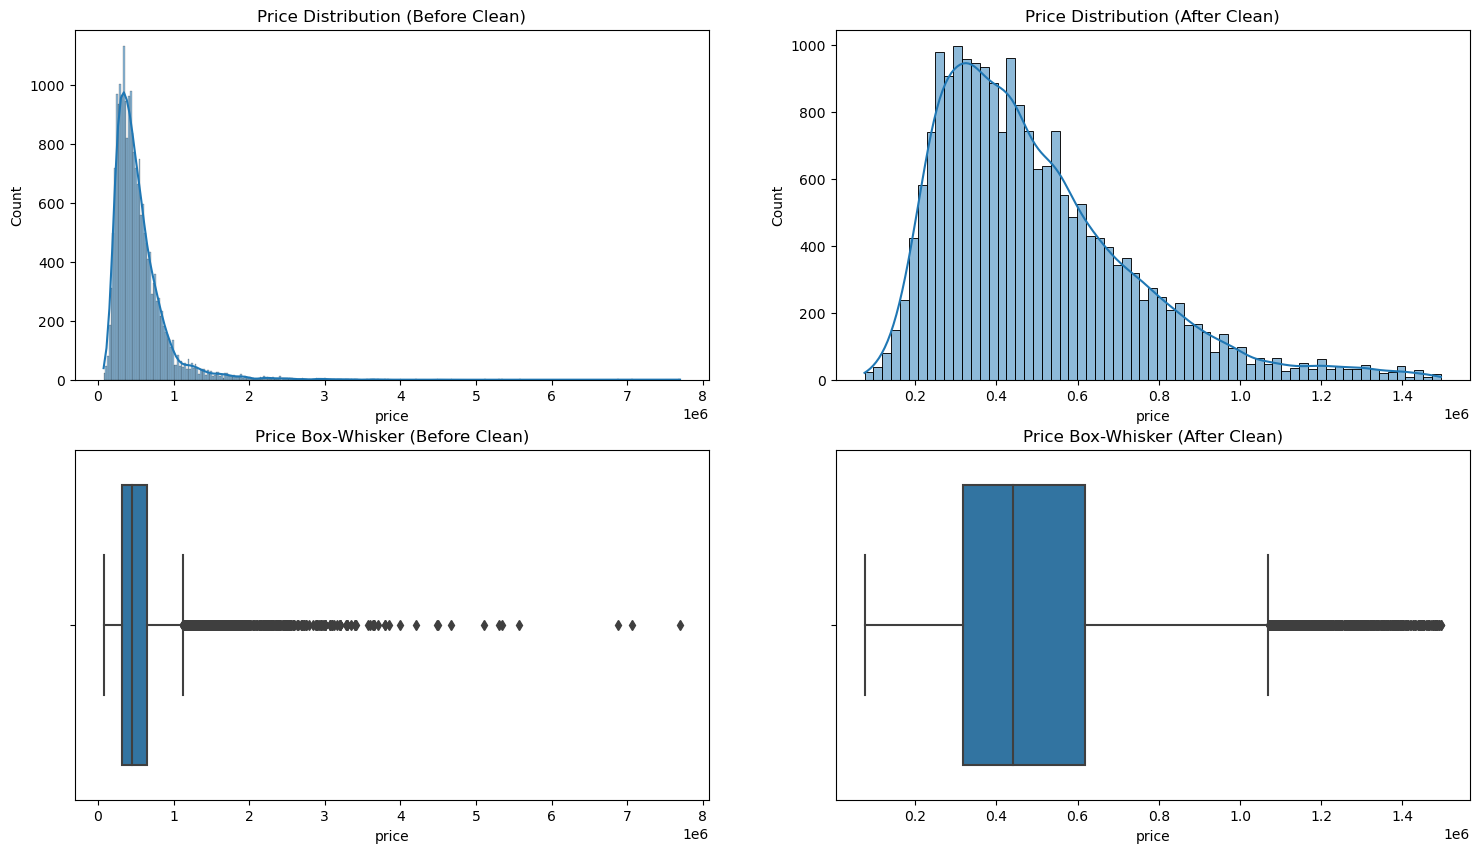

In [9]:
#View Outlier Mgmt
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

axes[0,0].set_title('Price Distribution (Before Clean)')
sns.histplot(df_raw['price'], kde=True, ax=axes[0,0]);

axes[1,0].set_title('Price Box-Whisker (Before Clean)')
sns.boxplot(x=df_raw['price'],ax=axes[1,0]);

axes[0,1].set_title('Price Distribution (After Clean)')
sns.histplot(df['price'], kde=True, ax=axes[0,1]);

axes[1,1].set_title('Price Box-Whisker (After Clean)')
sns.boxplot(x=df['price'], ax=axes[1,1]);

In [10]:
#Engineer Days since prev_sold and peep corr

## EDA 🔍
- _Univariate_ Analysis of Price
- _Bivariate_ Analysis
- Correlation
- Sig. Testing

#### Distributions, Correlation, Multidimensional Viz 

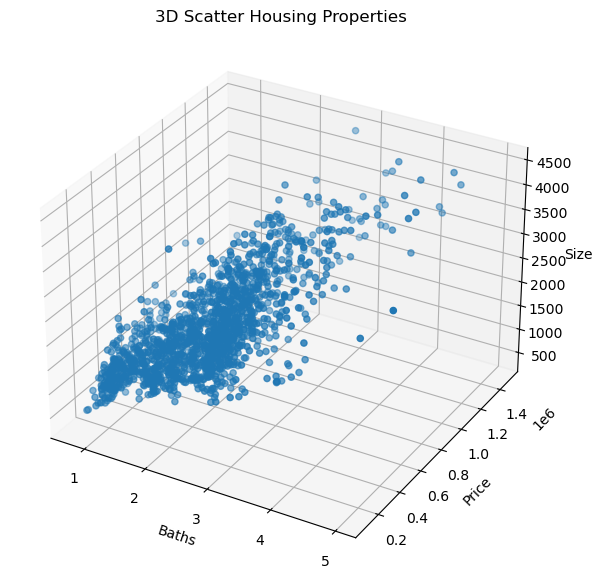

In [11]:
#QI DATA
fig = plt.figure(figsize=(7,9))
ax = plt.axes(projection = '3d') #3D scatter plot

sampled_df = df.sample(n=1500) #Sample df for Viz

ax.scatter(sampled_df['bathrooms'], sampled_df['price'], sampled_df['sqft_living'])

ax.set_xlabel('Baths')
ax.set_ylabel('Price')
ax.set_zlabel('Size')
ax.set_title('3D Scatter Housing Properties')
plt.show()

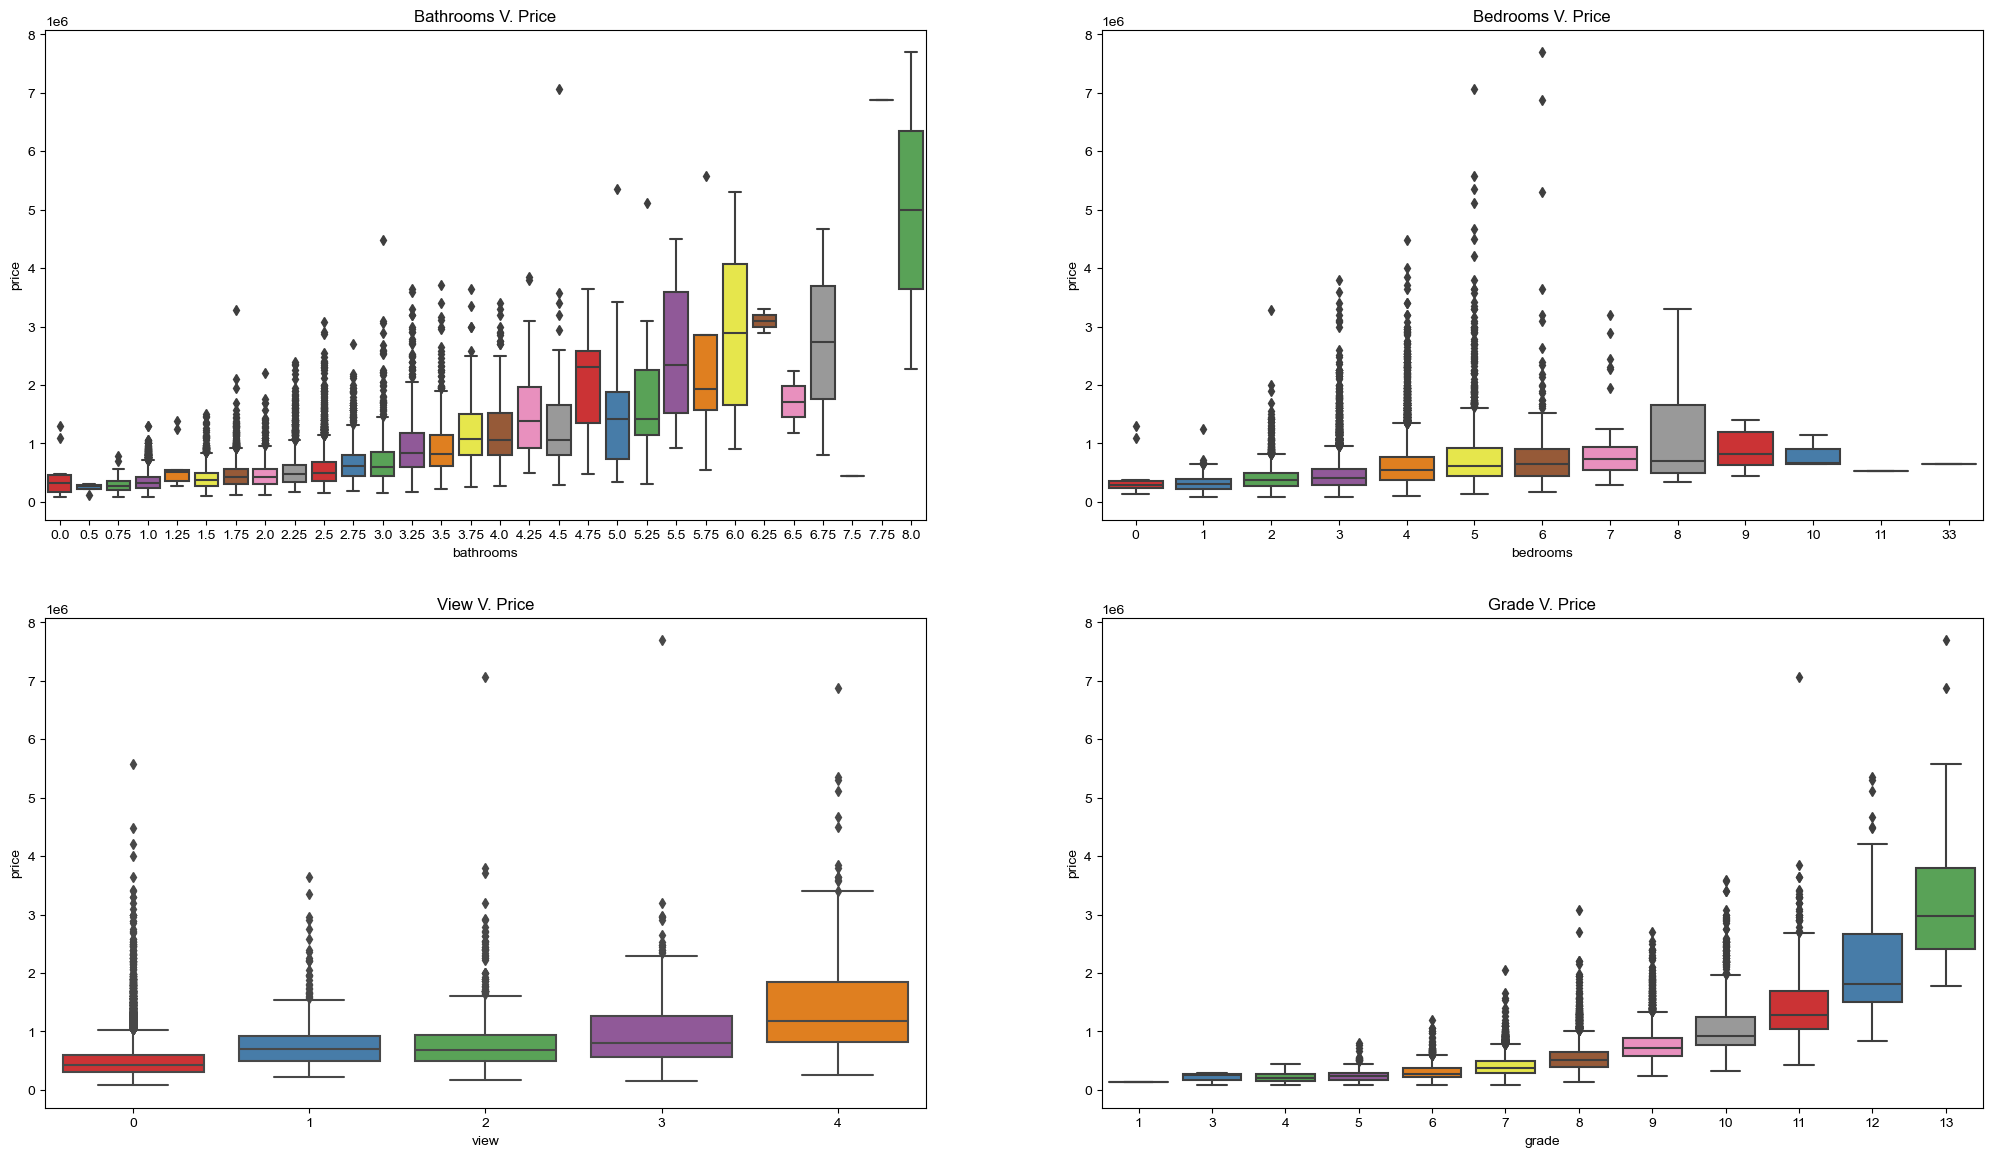

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(25, 14))
# plt.figure(figsize=(12, 8)) 
sns.set_style("darkgrid")

axes[0,0].set_title('Bathrooms V. Price')
sns.boxplot(x="bathrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,0])

axes[0,1].set_title('Bedrooms V. Price')
sns.boxplot(x="bedrooms", y="price", data=df_raw, palette="Set1", ax=axes[0,1])

axes[1,0].set_title('View V. Price')
sns.boxplot(x="view", y="price", data=df_raw, palette="Set1", ax=axes[1,0])

axes[1,1].set_title('Grade V. Price')
sns.boxplot(x="grade", y="price", data=df_raw, palette="Set1", ax=axes[1,1]);

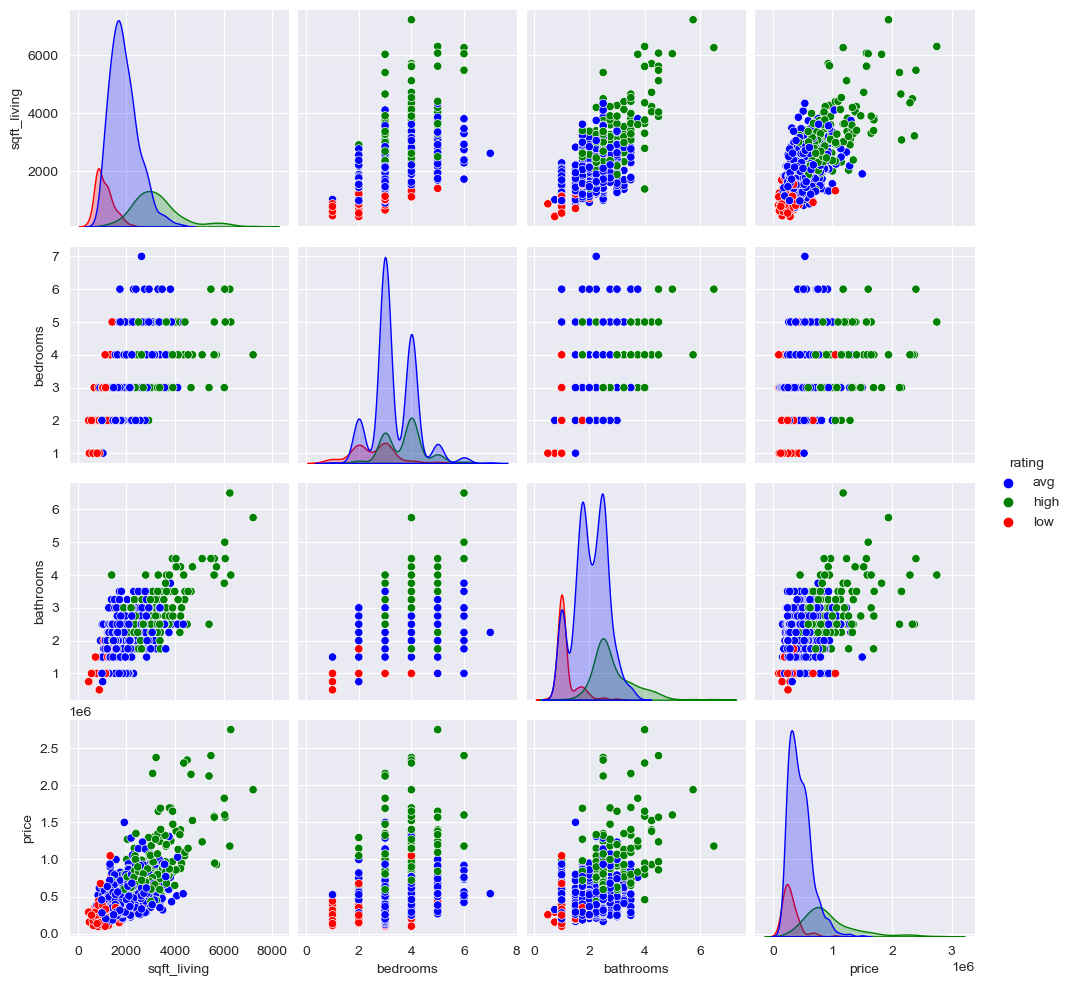

In [13]:
#Col Rating Engineered to better viz Grade
df_raw['rating'] = df_raw['grade'].apply(lambda i: 'low' if i <= 6 else 'avg' if i <= 8 else 'high')
sns.pairplot(data=df_raw[['sqft_living', 'rating', 'bedrooms','bathrooms', 'price']].sample(1000), hue='rating',
            palette={"low": "red", "avg": "blue", "high": "green"});

In [14]:
from sklearn.linear_model import LinearRegression #SQFT_Living LR VIZ
lr = LinearRegression()
lr.fit(np.array(df_raw['sqft_living']).reshape(-1, 1), np.array(df_raw['price']).reshape(-1, 1))

LinearRegression()

In [15]:
bo = lr.intercept_
b1 = lr.coef_
print('Intercept: {} \nSlope (Sqft): {}'.format(bo,b1))

Intercept: [-43580.74309448] 
Slope (Sqft): [[280.6235679]]


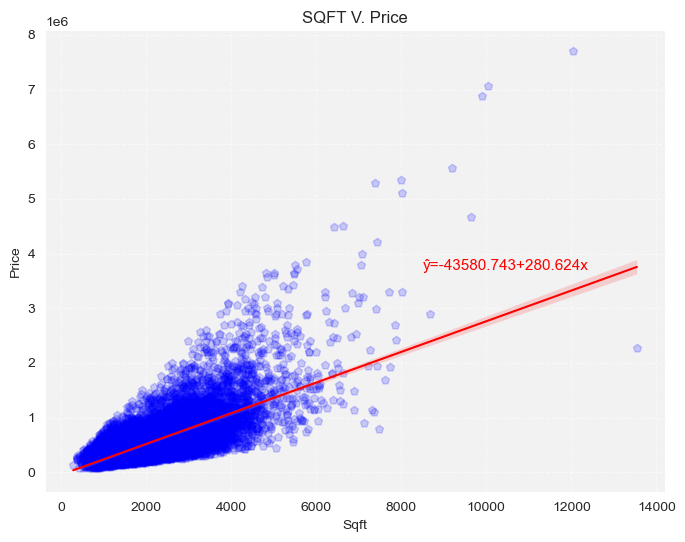

In [16]:
# Create a figure and set the background color
plt.figure(figsize=(8, 6))
 
sns.set_style("darkgrid", {'axes.facecolor': '0.95'})

sns.regplot(df_raw['sqft_living'], df_raw['price'], marker = 'p', scatter_kws={"color": "blue", "alpha": 0.18}, 
    line_kws={"color": "red", "linewidth": 1.5})
plt.xlabel('Sqft')
plt.ylabel('Price')
plt.title('SQFT V. Price')
plt.text(8500, 3700000, f'ŷ={round(bo[0],3)}+{round(b1[0][0],3)}x',fontsize=11, color='red')
plt.grid(True, linestyle='--', alpha=0.5);

In [17]:
df_raw.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'population', 'rating'],
      dtype='object')

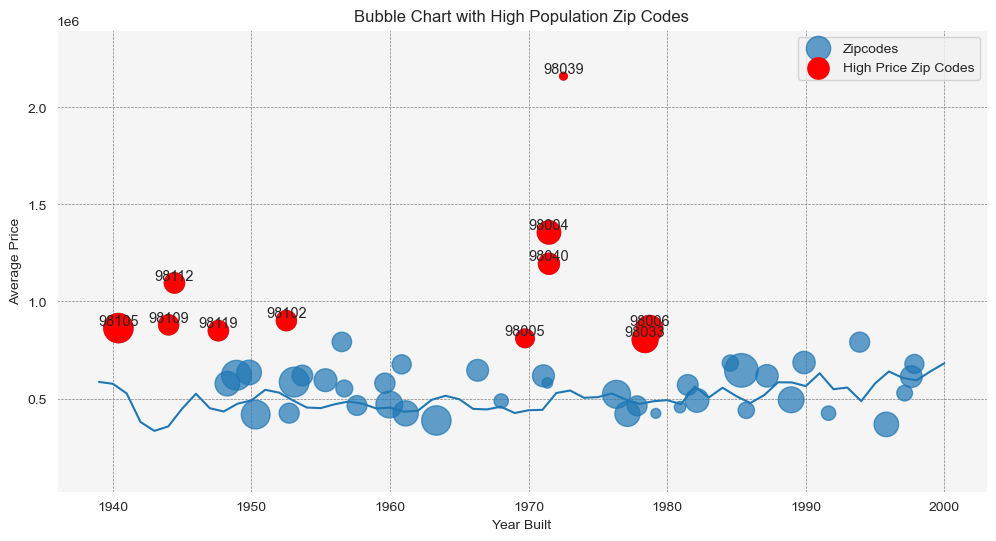

In [18]:
df_raw1 = df_raw.groupby(['zipcode', 'population']).agg({'price':'mean', 'yr_built':'mean'}).\
sort_values(by='price', ascending=False).iloc[0:50].reset_index()

yr_price = pd.DataFrame(df_raw.groupby('yr_built')['price'].mean()).reset_index().query('yr_built >= 1939 & yr_built <= 2000')

high_price_threshold = 60000

high_price_df = df_raw1[df_raw1['price'] >= df_raw1.iloc[10]['price']]

# Create a bubble chart
plt.figure(figsize=(12, 6))
plt.scatter(df_raw1['yr_built'], df_raw1['price'], s=df_raw1['population']/100, alpha=0.7, label='Zipcodes')


plt.scatter(high_price_df['yr_built'], high_price_df['price'], s=high_price_df['population'] / 100, color='red', label="High Price Zip Codes")

# Annotate high population zip codes
for i, row in high_price_df.iterrows():
    plt.annotate(int(row['zipcode']), (row['yr_built'], row['price']), fontsize=10.5, ha='center', va='bottom')

    
    
plt.plot(yr_price['yr_built'], yr_price['price'])
plt.xlabel('Year Built')
plt.ylabel('Average Price')
plt.title('Bubble Chart with High Population Zip Codes')
plt.legend()
plt.ylim(20000, 2400000)

plt.gca().set_facecolor('whitesmoke')

# Add a grid
plt.grid(color='grey', linestyle='--', linewidth=0.5)

plt.show()

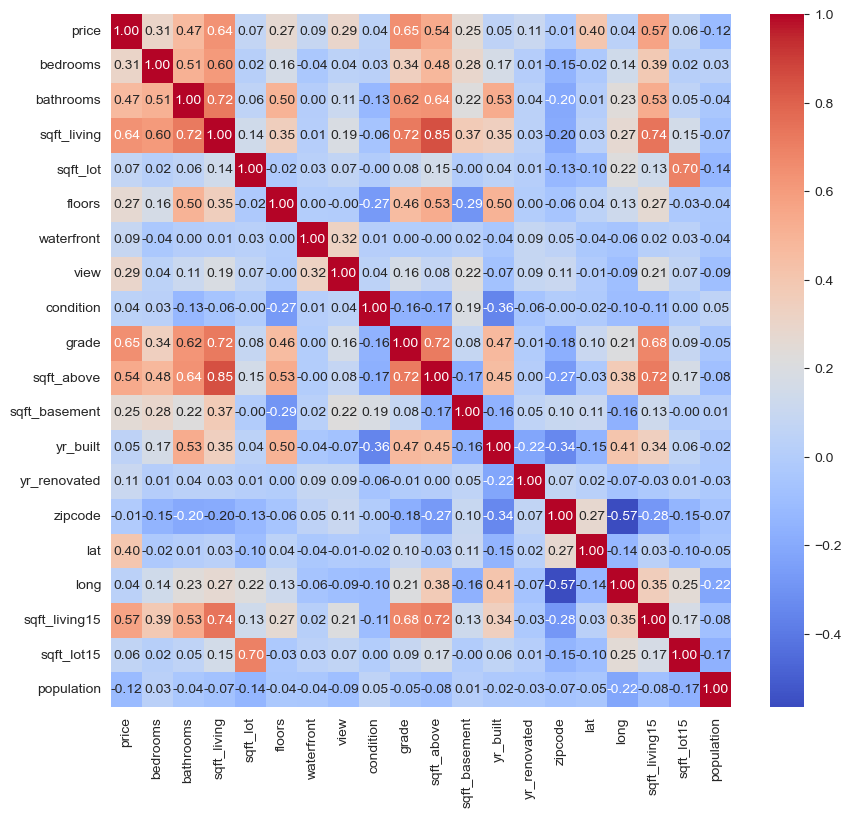

In [19]:
plt.figure(figsize=(10,9))
sns.heatmap(df.drop(columns=['id']).corr(), cmap='coolwarm', annot=True, fmt='.2f');

In [20]:
#Folium Map (ARNO)

In [21]:
sns.set_style("whitegrid")

## Hypothesis Testing

In [22]:
# (Sheba)

# K-means Clustering 
- `k = 5`
> **_Luxury_:
Label Homes as Low End, Average, and High on basis of clustering property features highest correlated w/ price to 5 randomly placed centroids on basis of Scaled Eucilidean Distance 
`vars = price, house_size, bathrooms`**

In [23]:
#Import Scaling+Clustering Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

In [24]:
df.reset_index(inplace=True)
df_k = df.copy() #df for K-means processes

### _Normalize Features_

In [25]:
df_k.head(2)

,index,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,population
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,24092
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,37081


In [26]:
#Normalize to Z-scores
scaler = StandardScaler()
df_k[['price_T', 'house_size_t', 'bath_t']] = scaler.fit_transform(df_k[['price', 'sqft_living', 'bathrooms']])

### _Elbow Function_
- Identify optimal K value respecting SSE of Eucidlidean Distance to Respective Centroid

In [27]:
def elbow(data, max_k): #Identify optimal K value respecting SSE
    k_vals = []
    sse = []
    
    for k in range(1, max_k+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        
        k_vals.append(k)
        sse.append(kmeans.inertia_)
        
    #Elbow Plot
    fig = plt.subplots(figsize=(10,5))
    plt.plot(k_vals, sse, 'o-')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.grid(True)
    plt.show()

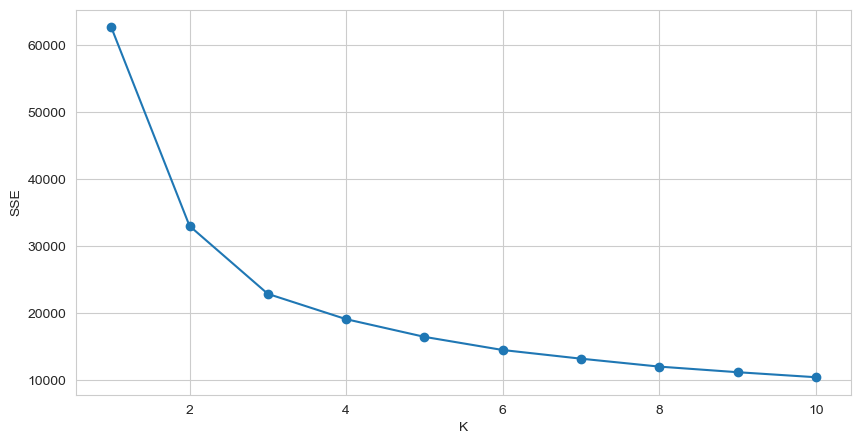

In [28]:
elbow(df_k[['price_T', 'house_size_t', 'bath_t']], 10) #QI DATA

## K-means Clustering Application
- `Luxury`

In [29]:
#Fit K-Means Cluster on highest Corr features w/ Price
kmeans = KMeans(n_clusters=5) #Fit data to Kmeans Algo
kmeans.fit(df_k[['price_T', 'bath_t', 'house_size_t']])

KMeans(n_clusters=5)

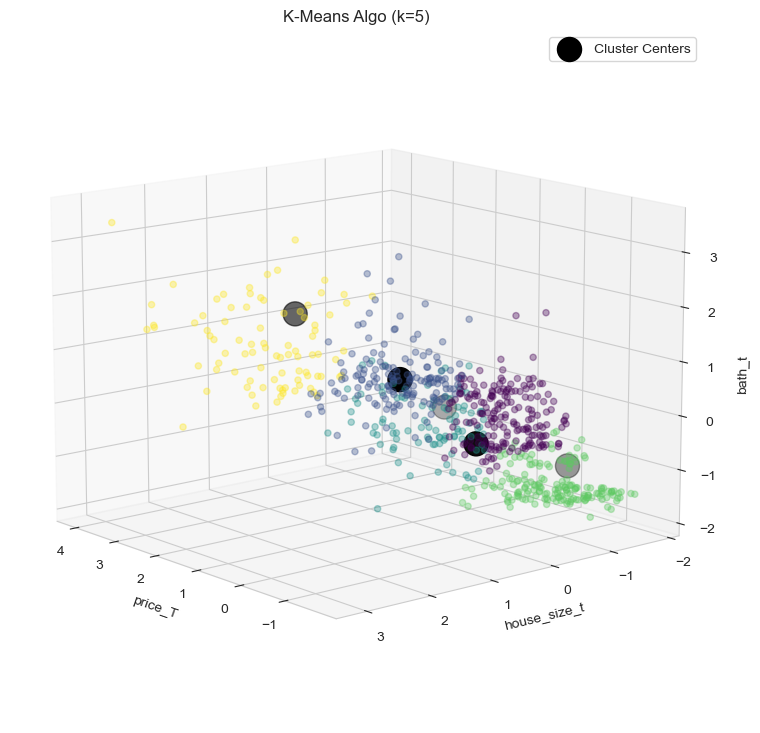

In [30]:
df_k['kmeans_5_multi'] = kmeans.labels_ #Labels added to k_means df
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')  # 3D scatter plot

df_k_sampled = df_k.sample(700, random_state=100)  # Sample df for Viz

# Adjust marker style, color, size, and transparency for the scatter points
scatter = ax.scatter(df_k_sampled['price_T'], df_k_sampled['house_size_t'], df_k_sampled['bath_t'],
                     c=df_k_sampled['kmeans_5_multi'], cmap='viridis', s=20, marker='o', alpha=.36)

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', s=300, marker='o', edgecolors='k', label='Cluster Centers')

ax.set_xlabel('price_T')
ax.set_ylabel('house_size_t')
ax.set_zlabel('bath_t')
ax.set_title('K-Means Algo (k=5)')
ax.legend()

ax.view_init(elev=13, azim=140)
plt.show()

In [31]:
df['kmeans_5_multi'] = kmeans.labels_ #Labels added to main df

In [32]:
kmeans.cluster_centers_#[:, 0]

array([[-0.59013222,  0.12721245, -0.34470089],
       [ 0.20842326,  0.79545115,  0.79991861],
       [ 0.72370081, -0.32733153, -0.06869183],
       [-0.72342282, -1.33025004, -1.06455749],
       [ 1.95887392,  1.26422698,  1.73642489]])

# Modeling Tasks
#### **Regression** - Predict Home Prices 💲🏡
- `Multiple Linear Regression` - _Coefficient + Trend analysis_
- `Gradient Boosted RF Regression`
- `XGBoost`

### Multiple Linear Regression
### $$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n + \epsilon $$

- Coefficient Analysis between lineary associated variables
- Analysis of R2 & Feature Significance

In [33]:
import statsmodels.api as sm

#Initialize Predictors & Outcome
Y = df['price']
X = df[['bathrooms', 'bedrooms', 'sqft_living',
       'grade', 'view', 'floors', 'yr_built']]

In [34]:
#OLS Model (Coef Analysis)
ols_model = sm.OLS(Y, sm.add_constant(X))

# Apply HAC Covariance to Adjust for Multicolinearity  
results = ols_model.fit(cov_type='HAC', cov_kwds={'maxlags': 5})
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     2968.
Date:                Tue, 05 Dec 2023   Prob (F-statistic):               0.00
Time:                        19:27:10   Log-Likelihood:            -2.7891e+05
No. Observations:               20884   AIC:                         5.578e+05
Df Residuals:                   20876   BIC:                         5.579e+05
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.508e+06   9.79e+04     56.238      

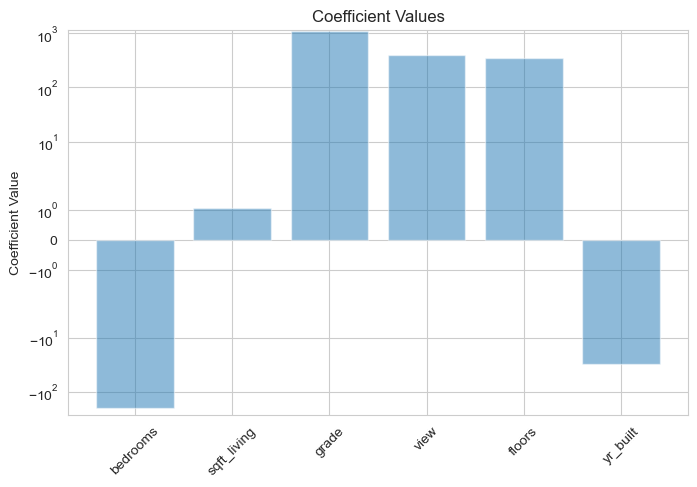

In [35]:
import matplotlib.pyplot as plt
import numpy as np

coefficients = results.params[1:]

plt.figure(figsize=(8, 5))  

x = np.arange(len(coefficients.index[1:]))
y =  [x/100 for x in coefficients.values[1:]]

plt.bar(x, y, align='center', alpha=0.5)

plt.ylabel('Coefficient Value')
plt.title('Coefficient Values')

plt.xticks(x, coefficients.index[1:], rotation=45)

plt.yscale('symlog')
plt.show()


## Tree-Based Methods
- `Random Forest Regression +Boosting`
- `XGBoost`
- `GWR`

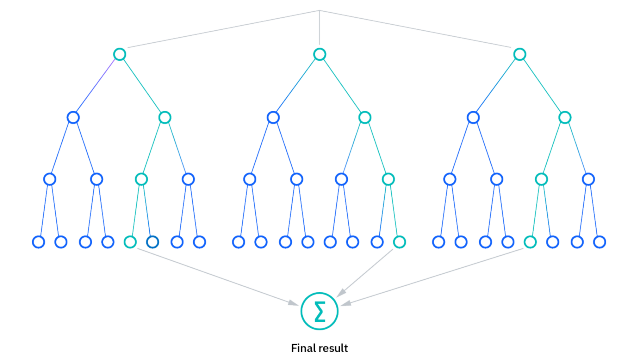

## Random Forest Regressor 🌲
- `Gradient Boosting`
- _Optimize Hyperparameters_ - `GridSearchCV` (3-Fold Cross Validaiton)
- Analyze Loss + Performance Metrics

In [36]:
#Import ML Libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score

In [37]:
#Split - Train/Test
x_train, x_test, y_train, y_test = train_test_split(df[['bedrooms', 'bathrooms', 'sqft_living',
                                                        'floors', 'view', 'condition', 'grade',
                                                       'sqft_basement', 'yr_built', 'yr_renovated',
                                                       'population']], df['price'], test_size=.2,
                                                   random_state=0)

In [38]:
#Search space 
param_map = {
    'n_estimators' : [100, 130, 170],
    'max_depth' : [3, 5, 8]
} ## 130 - 170 --> +tune learning rate/min_samples

scorer = make_scorer(r2_score)
gs= GridSearchCV(estimator=GradientBoostingRegressor(loss='squared_error'),
                           param_grid=param_map,
                           scoring=scorer,
                           cv=3,
                           verbose=4)

gs.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .....max_depth=3, n_estimators=100;, score=0.729 total time=   0.7s
[CV 2/3] END .....max_depth=3, n_estimators=100;, score=0.728 total time=   0.7s
[CV 3/3] END .....max_depth=3, n_estimators=100;, score=0.740 total time=   0.7s
[CV 1/3] END .....max_depth=3, n_estimators=130;, score=0.760 total time=   0.8s
[CV 2/3] END .....max_depth=3, n_estimators=130;, score=0.758 total time=   0.8s
[CV 3/3] END .....max_depth=3, n_estimators=130;, score=0.763 total time=   0.8s
[CV 1/3] END .....max_depth=3, n_estimators=170;, score=0.783 total time=   1.1s
[CV 2/3] END .....max_depth=3, n_estimators=170;, score=0.782 total time=   1.1s
[CV 3/3] END .....max_depth=3, n_estimators=170;, score=0.789 total time=   1.1s
[CV 1/3] END .....max_depth=5, n_estimators=100;, score=0.797 total time=   1.1s
[CV 2/3] END .....max_depth=5, n_estimators=100;, score=0.797 total time=   1.1s
[CV 3/3] END .....max_depth=5, n_estimators=100;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [3, 5, 8],
                         'n_estimators': [100, 130, 170]},
             scoring=make_scorer(r2_score), verbose=4)

In [42]:
#Loss function Analysis
gs.best_params_ #Optimal HyperParameters

{'max_depth': 5, 'n_estimators': 170}

In [43]:
gbr = GradientBoostingRegressor(loss='squared_error', n_estimators=170, max_depth=5)
gbr.fit(x_train, y_train) #Fit model

GradientBoostingRegressor(max_depth=5, n_estimators=170)

<div class="alert alert-block alert-success">
<b>Gradient Boosted Regression Summary:</b> *Best Parameters - {'max_depth': 5, 'n_estimators': 170}
*Test R2 Score (3-Fold Cross Validation ) - .812
</div>

## Loss Function
- Mean Squared Error:
## $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $

> Estimaters apply gradient boosting on error predictions w/ learning rate 0.1 at each stage to minimize error and shift toward global minima

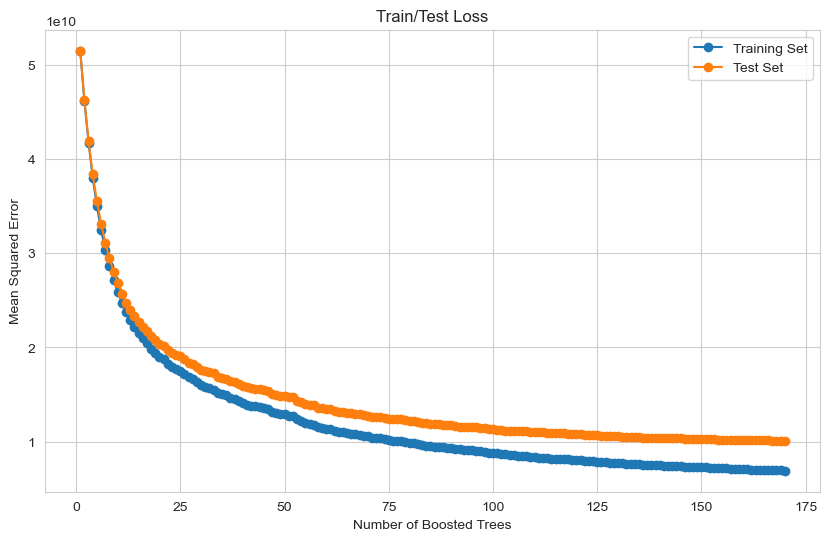

In [44]:
train_errors = [mean_squared_error(y_train, pred) for pred in list(gbr.staged_predict(x_train))]
test_errors = [mean_squared_error(y_test, pred) for pred in list(gbr.staged_predict(x_test))]


plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, gbr.n_estimators + 1), train_errors, label='Training Set', marker='o')
plt.plot(np.arange(1, gbr.n_estimators + 1), test_errors, label='Test Set', marker='o')
plt.xlabel('Number of Boosted Trees')
plt.ylabel('Mean Squared Error')
plt.title('Train/Test Loss')
plt.legend()
plt.show()

### Feature Importances

In [45]:
#Sorted Feature Importances
f_imp = sorted(np.vstack((gbr.feature_importances_, gbr.feature_names_in_)).T,key=lambda i: i[0], reverse=True)

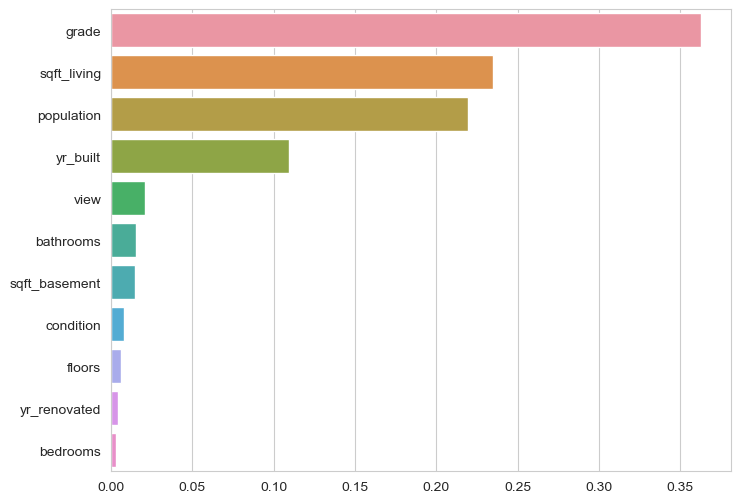

In [46]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.barplot(x=[i[0] for i in f_imp], y=[i[1] for i in f_imp]);

In [49]:
#Price Estimates Added 
df['price_est'] = gbr.predict(df[['bedrooms', 'bathrooms', 'sqft_living','floors', 'view', 'condition', 
                                  'grade', 'sqft_basement', 'yr_built', 'yr_renovated','population']])

### Performance Metrics
- _Function to Return Modeling Metrics (Regress)_
#### $ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $
#### $ \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100 $
#### $ \text{ME} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $
#### $ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

In [50]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def performance(y_true, y_pred):
    return pd.DataFrame({'MAPE': [mean_absolute_percentage_error(y_true, y_pred)],
             'MSE':[mean_squared_error(y_true, y_pred)],
             'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred))],
             'ME': [np.mean(y_true-y_pred)]}).rename(index={0:'Results'})


In [51]:
performance(y_test, gbr.predict(x_test)) #Metrics for Gradient Boosted RF Regressor

,MAPE,MSE,RMSE,ME
Results,0.152157,1.008379e+10,100418.075485,2529.32983


In [52]:
"""
To DO:
2.) Other model/gradient characteristics to show (Feature Importances)
4.) XGBoost
5.) Functionize/clean notebook
"""

'\nTo DO:\n2.) Other model/gradient characteristics to show (Feature Importances)\n4.) XGBoost\n5.) Functionize/clean notebook\n'

In [53]:
#Price Margin (1hr)
# Grade
# sqft_living

In [54]:
#Create price margin column
df['price_margin'] = df['price'] - df['price_est']
df['price_margin']

0        -18443.810014
1        -14929.119462
2        -87267.393599
3         91417.970743
4         44280.785034
             ...      
20879   -104909.160687
20880   -122673.233309
20881     93605.294964
20882    -48526.957641
20883     16504.294964
Name: price_margin, Length: 20884, dtype: float64

In [55]:
from sklearn.preprocessing import StandardScaler

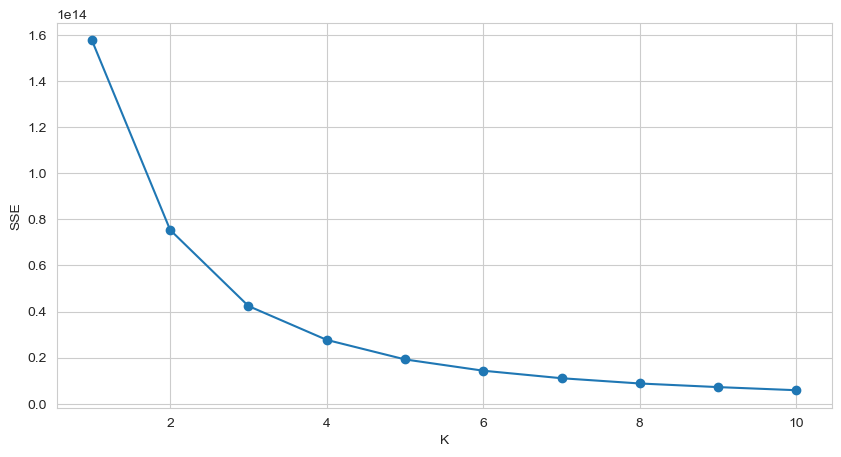

In [64]:
elbow(df[['price_margin', 'sqft_living', 'grade']], 10)

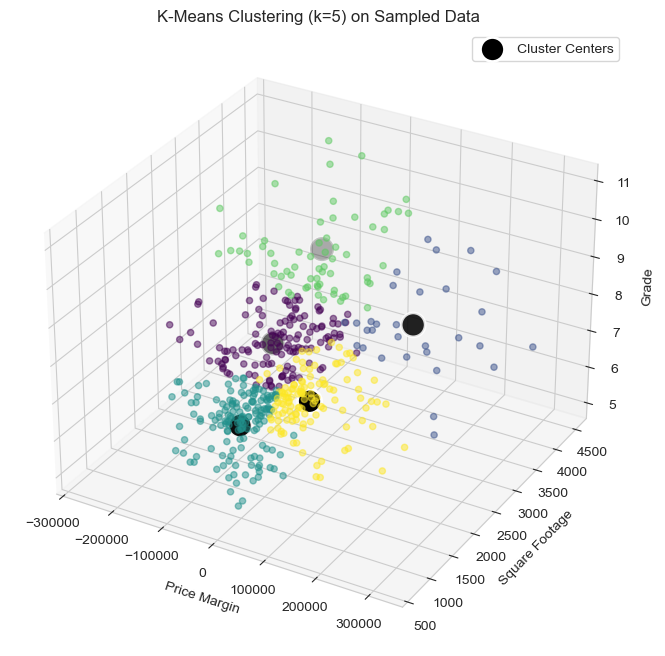

In [98]:
#Initialize the scaler
scaler = StandardScaler()

#Scale the features to add to the k-means
df_scaled = scaler.fit_transform(df[['price_margin', 'sqft_living', 'grade']])

#Fit the K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(df_scaled)

#Assign the cluster labels to df
df['kmeans_5_multi_value'] = kmeans.labels_

#Get the cluster centers
centers_scaled = kmeans.cluster_centers_

#Inverse transform the cluster centers to original...
centers = scaler.inverse_transform(centers_scaled)

#Downsample the data to see better in plot
df.reset_index(drop=True, inplace=True)

#Use min function to ensure sample size not greater than size of df
sample_size = min(500, len(df))

#Get random indeces for sampling
indices = np.random.choice(df.index, size=sample_size, replace=False)
df_sampled = df.iloc[indices]

#Inverse scale the sampled data for viz purposes
df_sampled_scaled = scaler.inverse_transform(df_scaled[indices])

#Plot the clusters, cluster centers, and the data points using sampled data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_sampled_scaled[:, 0], df_sampled_scaled[:, 1], df_sampled_scaled[:, 2],
                     c=df_sampled['kmeans_5_multi_value'], cmap='viridis', s=20, marker='o', alpha=0.5)

ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='black', s=300, marker='o', edgecolors='white', linewidths=2, label='Cluster Centers')


ax.set_xlim(-300000, 350000)

# Set axis labels and title
ax.set_xlabel('Price Margin')
ax.set_ylabel('Square Footage')
ax.set_zlabel('Grade')
ax.set_title('K-Means Clustering (k=5) on Sampled Data')
ax.legend()

#ax.view_init(elev=0, azim=30)  # elev and azim can be any angle in degrees


plt.show()

In [103]:
#Assign the cluster labels to df
df_scaled
df_scaled_final = pd.DataFrame(df_scaled, columns=['Price_Margin', 'Square_Footage', 'Grade'])
df_scaled_final['kmeans_5_multi_value'] = kmeans.labels_

In [126]:
grouped = df_scaled_final.groupby('kmeans_5_multi_value').agg({'Price_Margin': 'mean', 'Square_Footage': 'mean', 'Grade': 'mean'})
grouped['Weighted_val'] = -.6*grouped.Price_Margin + .1*grouped.Square_Footage + .3*grouped.Grade
grouped.sort_values(by='Weighted_val')

,Price_Margin,Square_Footage,Grade,Weighted_val
kmeans_5_multi_value,,,,
1,2.032416,1.017006,0.875070,-0.855228
4,0.785021,-0.346466,-0.355710,-0.612372
2,-0.307992,-0.928868,-0.866190,-0.167949
0,-0.517863,0.241835,0.204840,0.396353
3,-0.450439,1.569245,1.594348,0.905492


In [107]:
grouped = df.groupby('kmeans_5_multi_value').agg({'price_margin': 'mean', 'sqft_living': 'mean', 'grade': 'mean'})
grouped['Weighted_val'] = -.25*grouped.price_margin + .25*grouped.sqft_living + .5*grouped.grade
grouped.sort_values(by='Weighted_val')

,price_margin,sqft_living,grade,Weighted_val
kmeans_5_multi_value,,,,
1,177193.585165,2780.096140,8.503277,-43599.120618
4,68751.491048,1725.740045,7.187472,-16752.844015
2,-26269.326793,1275.375566,6.641726,6889.496453
3,-38652.925307,3207.135593,9.272246,10469.651348
0,-44514.410903,2180.666168,7.786746,11677.662641
